# Multistage Hypersolver pre-train (separated training and ablation study)

In [1]:
%load_ext autoreload
%autoreload 2

import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from math import pi as π

import sys; sys.path.append(2*'../') # go n dirs back
from src import *

from torchdyn.core import NeuralODE
from torchdyn.datasets import *
from torchdyn.numerics import odeint, Euler, HyperEuler
from torchdyn.numerics.solvers import Midpoint, SolverTemplate
from torchdyn.numerics.hypersolvers import HyperMidpoint

device = 'cpu' # feel free to change!

In [2]:
class MultiStageHypersolver(SolverTemplate):
    """
    Explicit multistage ODE stepper: inner stage is a vector field corrector
    while the outer stage is a residual approximator of the ODE solver
    """
    def __init__(self, inner_stage: nn.Module, outer_stage: nn.Module,
                       base_solver=Midpoint, dtype=torch.float32):
        super().__init__(order=base_solver().order)
        self.dtype = dtype
        self.stepping_class = 'fixed'
        self.base_solver = base_solver
        self.inner_stage = inner_stage
        self.outer_stage = outer_stage

    def step(self, f, x, t, dt, k1=None):
        # Correct vector field with inner stage and propagate
        self.vector_field = f
        _, _x_sol, _ = self.base_solver().step(self.corrected_vector_field, x, t, dt, k1=k1)
        # Residual correction with outer stage
        x_sol = _x_sol + dt**self.base_solver().order * self.outer_stage(t, f(t, x))
        return _, x_sol, _ 

    def corrected_vector_field(self, t, x):
        return self.vector_field(t, x) + self.inner_stage(t, x)


class HyperNetwork(nn.Module):
    """Simple hypernetwork using as input the current state, vector field and controller"""
    def __init__(self, net, sys):
        super().__init__()
        self.net = net
        self.sys = sys
    
    def forward(self, t, x):
        xfu = torch.cat([x, self.sys.cur_f, self.sys.cur_u], -1)
        return self.net(xfu)
        

In [3]:
# System we have
sys = CartPole(RandConstController())

# Real system
sys_nominal = CartPole(RandConstController())
sys_nominal.frictioncart = 0.1
sys_nominal.frictionpole = 0.03


# Initial distribution
x0 = 2*π # limit of the state distribution (in rads and rads/second)
init_dist = torch.distributions.Uniform(torch.Tensor([-x0, -x0, -x0, -x0]), torch.Tensor([x0, x0, x0, x0]))
u_min, u_max = -30, 30


## Training loop (inner stage only)
We train via stochastic exploration
(This will take some time)

In [4]:

hdim = 32
base_net_inner = nn.Sequential(nn.Linear(9, hdim), Snake(hdim), nn.Linear(hdim, hdim), Snake(hdim), nn.Linear(hdim, 4))
base_net_outer = nn.Sequential(nn.Linear(9, hdim), Snake(hdim), nn.Linear(hdim, hdim), Snake(hdim), nn.Linear(hdim, 4))
# base_net_inner = nn.Sequential(nn.Linear(9, 32), nn.Softplus(), nn.Linear(32, 32), nn.Tanh(), nn.Linear(32, 4))
# base_net_outer = nn.Sequential(nn.Linear(9, 32), nn.Softplus(), nn.Linear(32, 32), nn.Tanh(), nn.Linear(32, 4))

inner_stage = HyperNetwork(base_net_inner, sys)
outer_stage = HyperNetwork(base_net_outer, sys)
# Avoid outer stage being trained
def dummy_stage(t, x):
    return 0

# Use only inner stage
multistagehs = MultiStageHypersolver(inner_stage, dummy_stage, base_solver=Midpoint)
opt = torch.optim.Adam(multistagehs.inner_stage.parameters(), lr=1e-2) # only train inner
scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[3e5, 4e5], gamma=0.1)
# opt = torch.optim.Adam(multistagehs.inner_stage.parameters(), lr=1e-3)

loss_func = nn.MSELoss()
epochs = 50000
bs = 128
dt = 0.05
span = torch.linspace(0, dt, 2)
losses = []
for i in range(epochs):
    x0 = init_dist.sample((bs,)).to(device)
    val = torch.Tensor(bs, 1).uniform_(u_min, u_max).to(device)
    sys.u.u0 = val
    sys_nominal.u.u0 = val
    
    # Compute residuals
    _, sol_gt = odeint(sys_nominal._dynamics, x0, span, solver='rk4')[-1]
    _, sol_hs = odeint(sys._dynamics, x0, span, solver=multistagehs)[-1]
    loss = loss_func(sol_gt, sol_hs)

    # Optimization step
    loss.backward(); opt.step(); opt.zero_grad(); scheduler.step()
    print(f'Step: {i}, Residual loss: {loss:.8f}', end='\r')
    losses.append(loss.detach().cpu().item())

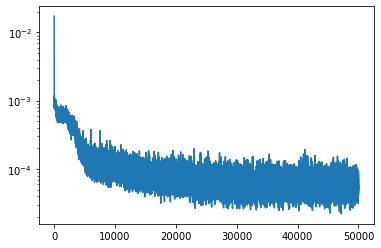

In [5]:
fig, ax = plt.subplots(1, 1)
ax.plot(losses)
ax.set_yscale('log')

## Outer stage training only
This is basically finetuning once we get the first stage

In [6]:
base_net_outer = nn.Sequential(nn.Linear(9, hdim), Snake(hdim), nn.Linear(hdim, hdim), Snake(hdim), nn.Linear(hdim, 4))
outer_stage = HyperNetwork(base_net_outer, sys)

# Use only inner stage
multistagehs.outer_stage = outer_stage # new outer stage in pre-trained hypersolver
opt = torch.optim.Adam(multistagehs.outer_stage.parameters(), lr=1e-2) # only train outer stage
scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[3e5, 4e5], gamma=0.1)

loss_func = nn.MSELoss()
epochs = 50000
bs = 128
dt = 0.05
span = torch.linspace(0, dt, 2)
losses = []
for i in range(epochs):
    x0 = init_dist.sample((bs,)).to(device)
    val = torch.Tensor(bs, 1).uniform_(u_min, u_max).to(device)
    sys.u.u0 = val
    sys_nominal.u.u0 = val
    
    # Compute residuals
    _, sol_gt = odeint(sys_nominal._dynamics, x0, span, solver='rk4')[-1]
    _, sol_hs = odeint(sys._dynamics, x0, span, solver=multistagehs)[-1]
    loss = loss_func(sol_gt, sol_hs)

    # Optimization step
    loss.backward(); opt.step(); opt.zero_grad(); scheduler.step()
    print(f'Step: {i}, Residual loss: {loss:.8f}', end='\r')
    losses.append(loss.detach().cpu().item())

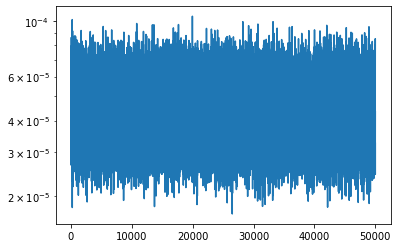

In [7]:
fig, ax = plt.subplots(1, 1)
ax.plot(losses)
ax.set_yscale('log')

In [8]:
# Save the model
torch.save(multistagehs, 'saved_models/hs_multistage_separated_snake.pt')

## Training residual one-step dynamic model
We can use the same `multistage hypersolver` with the inner stage corrector set to zero

In [9]:
hdim = 32
base_net_outer = nn.Sequential(nn.Linear(9, hdim), Snake(hdim), nn.Linear(hdim, hdim), Snake(hdim), nn.Linear(hdim, 4))
outer_stage = HyperNetwork(base_net_outer, sys)
# Avoid outer stage being trained
def dummy_stage(t, x):
    return 0

# Use only inner outer stage (residual dynamics)
residual_dynamics_solver = MultiStageHypersolver(dummy_stage, outer_stage, base_solver=Midpoint)
opt = torch.optim.Adam(residual_dynamics_solver.outer_stage.parameters(), lr=1e-2) 
scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[3e5, 4e5], gamma=0.1)

loss_func = nn.MSELoss()
epochs = 50000
bs = 128
dt = 0.05
span = torch.linspace(0, dt, 2)
losses = []
for i in range(epochs):
    x0 = init_dist.sample((bs,)).to(device)
    val = torch.Tensor(bs, 1).uniform_(u_min, u_max).to(device)
    sys.u.u0 = val
    sys_nominal.u.u0 = val
    
    # Compute residuals
    _, sol_gt = odeint(sys_nominal._dynamics, x0, span, solver='rk4')[-1]
    _, sol_hs = odeint(sys._dynamics, x0, span, solver=residual_dynamics_solver)[-1]
    loss = loss_func(sol_gt, sol_hs)

    # Optimization step
    loss.backward(); opt.step(); opt.zero_grad(); scheduler.step()
    print(f'Step: {i}, Residual loss: {loss:.8f}', end='\r')
    losses.append(loss.detach().cpu().item())

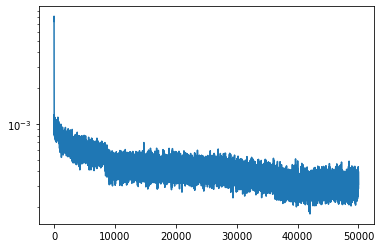

In [10]:
fig, ax = plt.subplots(1, 1)
ax.plot(losses)
ax.set_yscale('log')

In [11]:
# Save the model
torch.save(residual_dynamics_solver, 'saved_models/residual_dynamics_solver.pt')